# Plotting RBush

We want to see the structure of a RBush -- we want to plot the 2D spatial distribution of the items in a RBush tree.

We'll do that using [datashader][ds] and its companions, [xarray][xr], [bokeh][bk], [holoviews][hv], [pandas][pd], [numpy][np].

This exercise is based on:
* https://anaconda.org/jbednar/plotting_pitfalls/notebook
* https://anaconda.org/jbednar/pipeline/notebook

After a first approach, investigate/exercise the following:
* does bokeh-webgl engine support Rectangle glyph?


[ds]: http://datashader.readthedocs.io/
[xr]: http://xarray.pydata.org/
[bk]: https://bokeh.pydata.org
[hv]: http://holoviews.org/
[pd]: https://pandas.pydata.org/
[np]: http://www.numpy.org/

In [1]:
import datashader as ds
import xarray as xr
import bokeh as bk
import pandas as pd
import numpy as np
from numba import njit
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

import rbush
from rbush.data import generate_data_array

In [2]:
print(ds.__version__)
print(xr.__version__)
print(bk.__version__)
print(pd.__version__)
print(np.__version__)

0.6.2
0.10.0
0.12.13
0.20.3
1.13.1


[RBush](https://github.com/parietal-io/py-rbush)
```
rbush.__version__ : '0.0.2+9.g355496a'
```

In [3]:
import rbush

In [4]:
from rbush.data import generate_data_array

def gaussian_grid(N, INCREMENT, SIZE):
    arrays = []

    # bottom-left
    arr = generate_data_array(N, SIZE)
    arr += SIZE
    arrays.append(arr)

    # top-right
    arr = generate_data_array(N, SIZE)
    arr += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-right
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT - SIZE
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT - SIZE
    arr[:,3] += SIZE
    arrays.append(arr)

    # top-left
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # top-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += SIZE
    arrays.append(arr)

    # left-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT // 2
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT // 2
    arrays.append(arr)

    data = np.concatenate(arrays, axis=0)
    return data

N = int(1e5)
EXTENT = 1000
SIZE = 100
data = gaussian_grid(N, EXTENT, SIZE)
print('Length: {:,}'.format(len(data)))
data

Length: 700,000


array([[ 200.07061542,   73.5805063 ,  372.07627107,   15.68947759],
       [  75.59252551,   34.05099829,    4.63635817,  -64.79338077],
       [ 168.05487777,  175.80598612,  123.94449649,  354.87785146],
       ..., 
       [  93.36739139,  500.24811504,  252.32030743,  561.73548783],
       [ 121.00417534,  523.86716095,  -11.75535184,  423.70425   ],
       [ 107.23742118,  537.02710283,  349.71206607,  576.26314712]])

In [5]:
t = rbush.RBush()
t.load(data)

In [6]:
items = t.all()
bboxes = np.asarray([[i.xmin, i.ymin, i.xmax, i.ymax] for i in items])
bboxes

array([[-207.53382782, -213.40469205, -237.19060329, -133.07543346],
       [-206.64840399, -191.09839397, -108.97485374, -230.5690685 ],
       [-178.02646187, -179.9603459 , -127.43560233, -212.57070874],
       ..., 
       [-190.3567927 , -133.84924443, -169.65785964,  -19.25467846],
       [-169.32039064, -177.00614267,  -96.17974737, -322.38591592],
       [ 107.23742118,  537.02710283,  349.71206607,  576.26314712]])

In [7]:
# Apart from (raw) permutations, 'data' and 'bboxes' should contain the same information
assert data.shape==bboxes.shape

In [8]:
print(data.min(axis=0))
print(data.max(axis=0))
print(data.mean(axis=0))

[-330.55549239 -334.93244012 -578.35764219 -543.03985288]
[ 1327.99409693  1374.11883856  1557.4229118   1532.20470186]
[ 442.72284082  500.07293312  442.59477349  500.33060807]


In [9]:
print(bboxes.min(axis=0))
print(bboxes.max(axis=0))
print(bboxes.mean(axis=0))

[-277.15025227 -213.40469205 -356.72773254 -357.37881808]
[ 596.41129049  537.02710283  497.5975684   576.26314712]
[-182.10607101 -153.2020907  -159.48881059 -108.04781197]


**We see now that RBush has a (big) bug!** To not deviate from our exercise, let's use the `data` array, it's the same structure (as `bboxes`)

Datashader works in a canvas represented by an `xarray` where each element is a bin.
The bin represents a pixel in a (data) coordinates system.
Each bin contains information aggregated from the dataset(s) at that (pixel) position.

Let's say we want to count the number of items (bounding-boxes in our dataset) that cover each position in the dataset parameters space (xmin,ymin,xmax,ymax) -- a heatmap of the items distribution.
Each bin in the datashader (xarray) canvas will contain the number counts.

As a first approach, let's do the representation of items' centroids.
Then we evolve to plotting the boxes' coverage area.

In [10]:
df = pd.DataFrame(data, columns=['xmin','ymin','xmax','ymax'])
df['x'] = df[['xmin','xmax']].mean(axis=1)
df['y'] = df[['ymin','ymax']].mean(axis=1)

In [11]:
# We will represent centroids
glyph = ds.glyphs.Point('x', 'y')
glyph

In [12]:
# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
# TODO: Numba-isze this and take sizes / resolution.
xres = 1
yres = 1

BORDER = 100
xlims = [int(df.xmin.min()) - BORDER, int(df.xmax.max()+1) + BORDER]
ylims = [int(df.ymin.min()) - BORDER, int(df.ymax.max()+1) + BORDER]

xsize = (xlims[1] - xlims[0])//xres
ysize = (ylims[1] - ylims[0])//yres

In [13]:
def def_pos2pix(pmin,res):
    pos_zero = int(pmin/res)
    def f(pos):
        return int(pos/res) - pos_zero
    return f


def def_pix2pos(pmin,res):
    def f(pix):
        return pix*res + pmin
    return f

pos2pix_x = def_pos2pix(xlims[0], xres)
pos2pix_y = def_pos2pix(ylims[0], yres)

pix2pos_x = def_pix2pos(xlims[0], xres)
pix2pos_y = def_pix2pos(ylims[0], yres)

In [14]:
canvas = ds.Canvas(plot_width=800, plot_height=400, x_range=xlims, y_range=ylims)

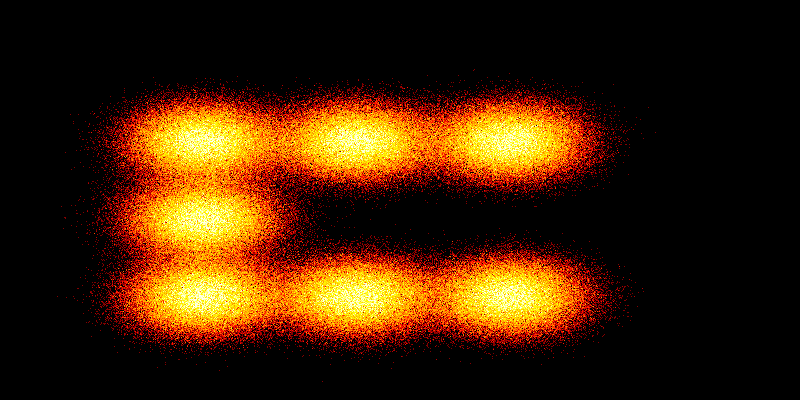

In [15]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

img = tf.shade(canvas.points(df,'x','y', agg=reductions.count()), cmap=Hot, how='eq_hist')
tf.set_background(img, 'black')

In [16]:
# TODO: Numba-isze this and take sizes / resolution.

def pos2pix_data(a, data):
    for i in range(len(data)):
        row = data[i]
        xi = pos2pix_x(row[0])
        yi = pos2pix_y(row[1])
        xf = pos2pix_x(row[2])
        yf = pos2pix_y(row[3])
        a[yi:yf,xi:xf] += 1

a = np.zeros((ysize,xsize),dtype=int)

%time pos2pix_data(a, data)

CPU times: user 9.29 s, sys: 33 ms, total: 9.32 s
Wall time: 9.34 s


In [17]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 2067, x: 2088)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) int64 -430 -429 -428 -427 -426 -425 -424 -423 -422 -421 ...
  * y        (y) int64 -434 -433 -432 -431 -430 -429 -428 -427 -426 -425 ...

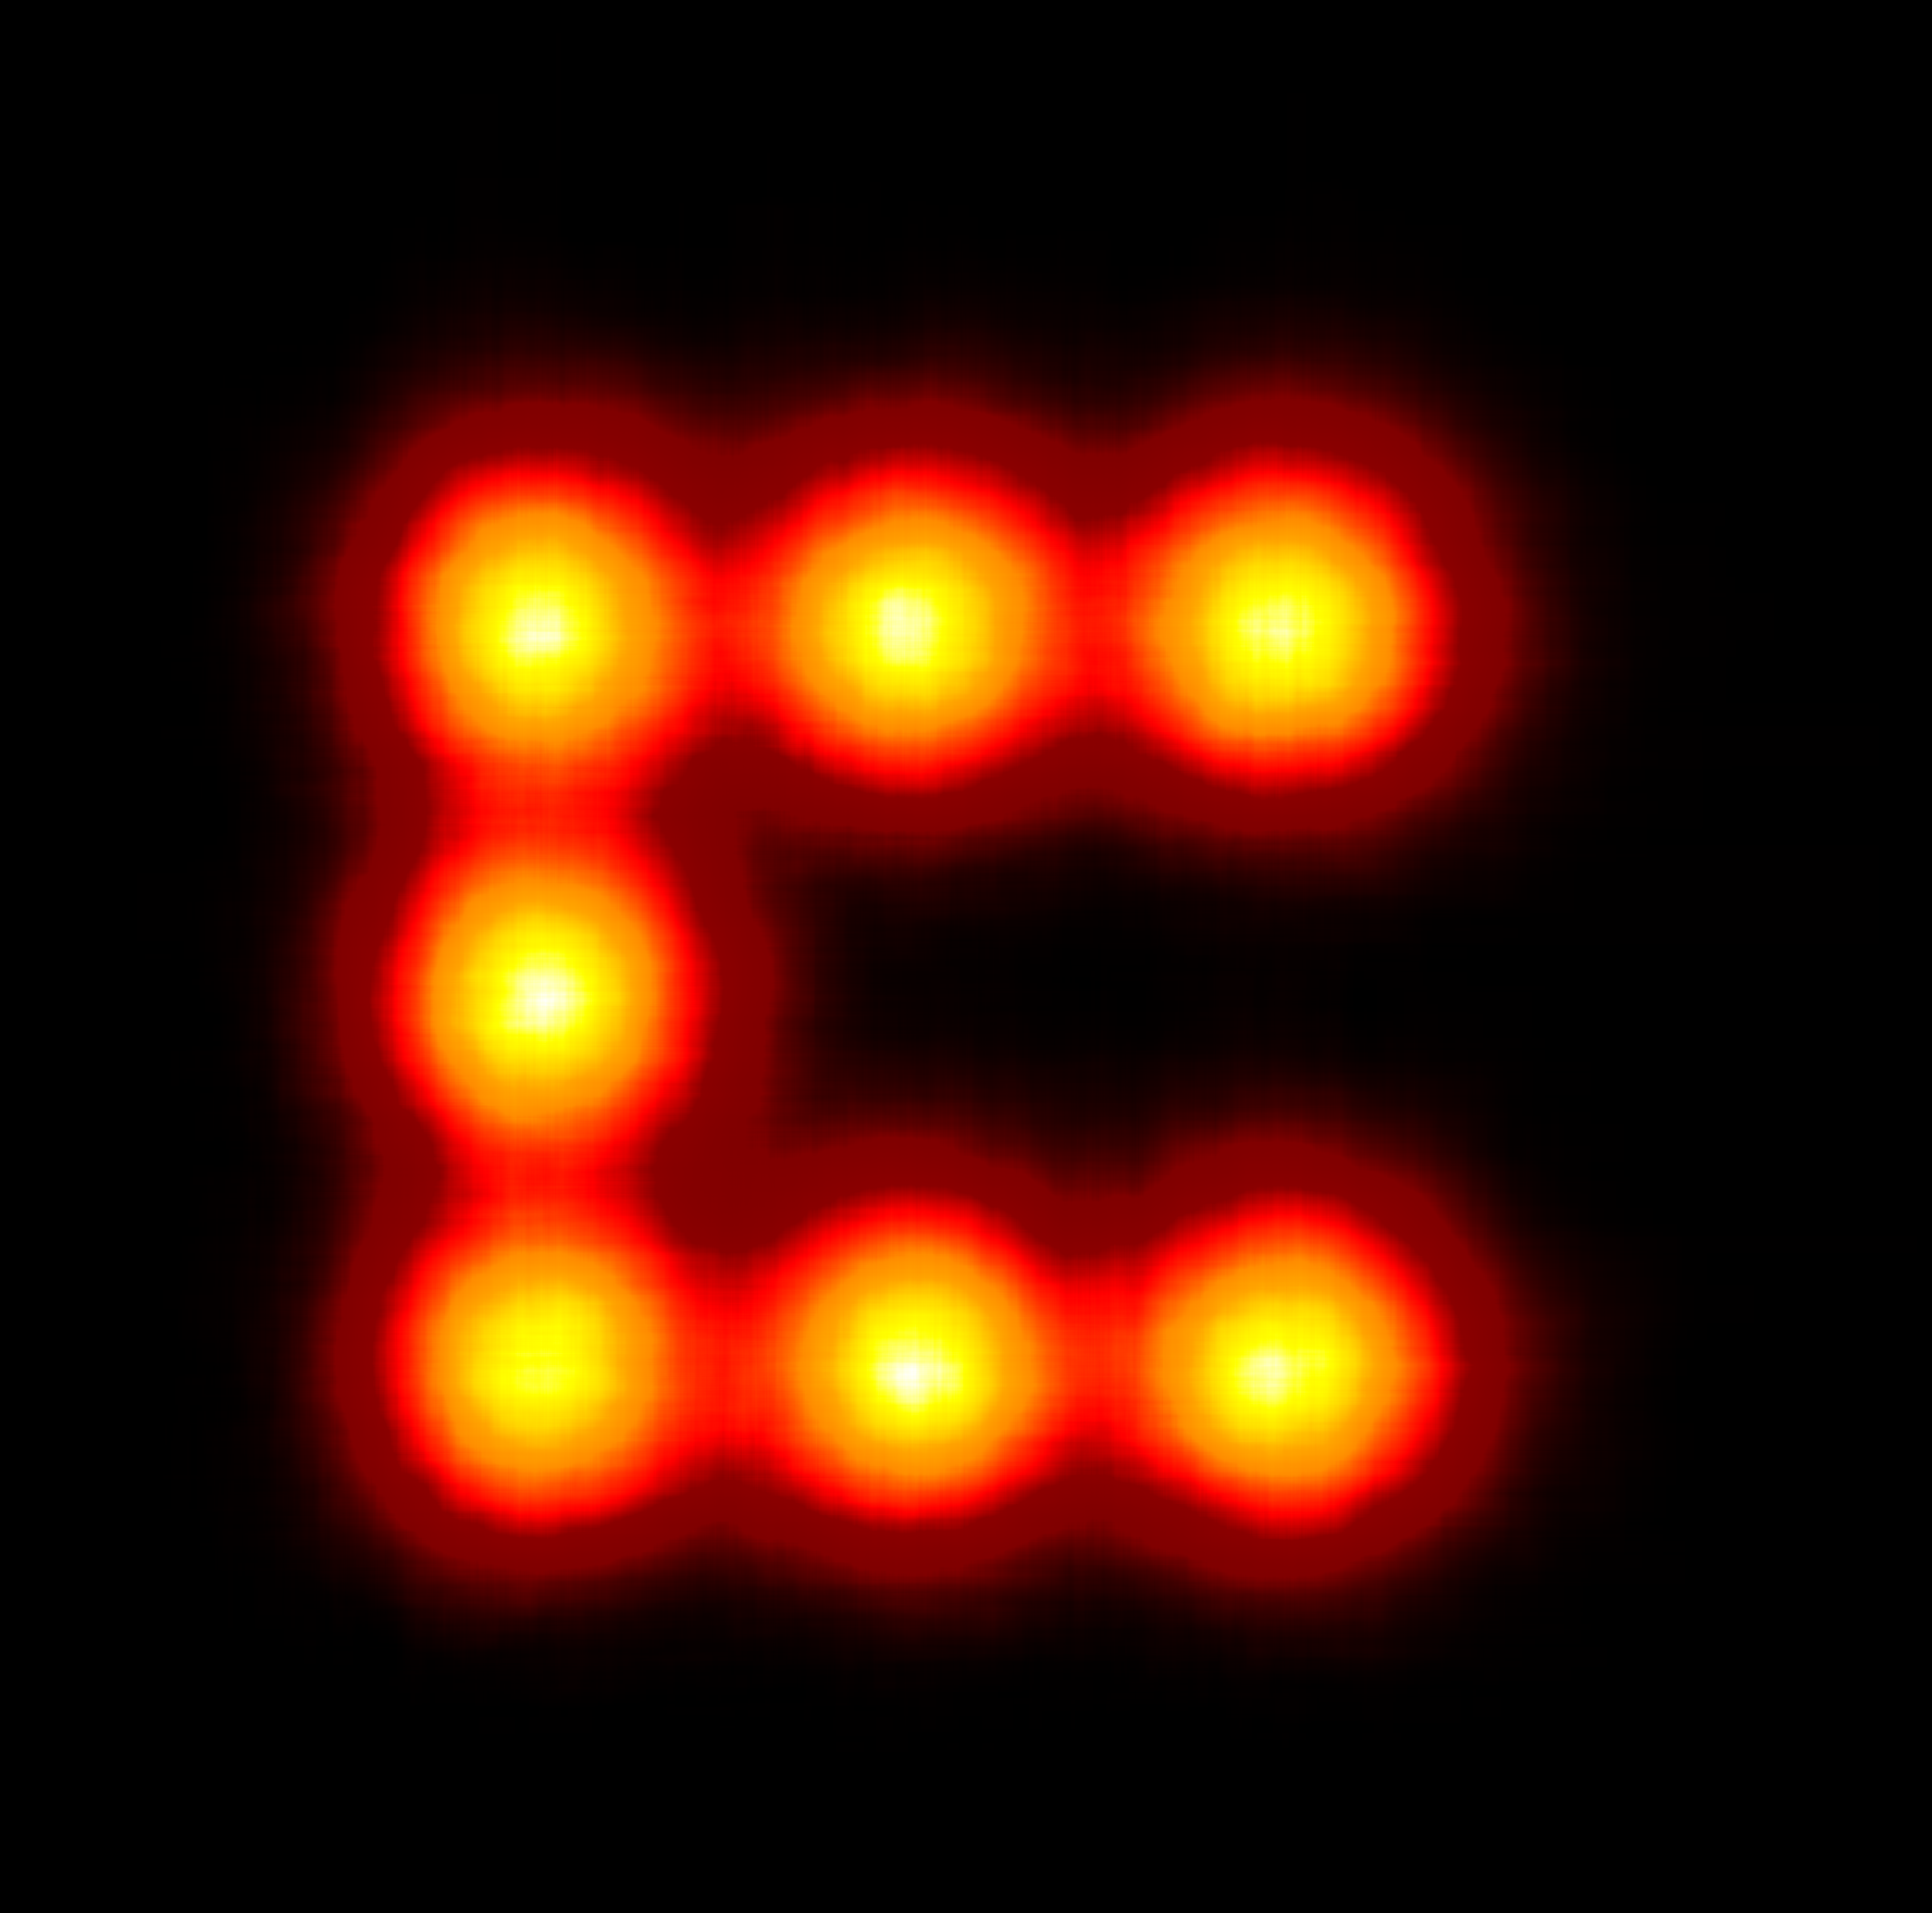

In [18]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

# Numba version

In [19]:
from numba import guvectorize, vectorize
from numba import int64,float64,void

@vectorize(["int64(float64, float64, float64)"])
def pos2pix(pos, min_pos, res):
    return int64((pos - min_pos)/res)

@guvectorize(["void(float64[:,:], float64[:], float64[:], int64[:,:])"],
              "(n,c),(c),(c)->(n,c)")
def rasterize(arr_data, posv, resv, pix):
    for i in range(arr_data.shape[0]):
        pix[i,:] = pos2pix(arr_data[i,:], posv, resv)

@njit('void(int64[:,:],int64[:,:])')
def pos2pix_data(arr_pix, arr_canvas):
    #a = np.zeros((ysize,xsize),dtype=int)
    for i in range(arr_pix.shape[0]):
        row = arr_pix[i]
        xi = row[0]
        yi = row[1]
        xf = row[2]
        yf = row[3]
        arr_canvas[yi:yf,xi:xf] += 1


a = np.zeros((ysize,xsize),dtype=int)

xmin = float(xlims[0])
ymin = float(ylims[0])
posv = np.array([xmin, ymin, xmin, ymin], dtype=float)
resv = np.array([xres, yres, xres, yres], dtype=float)

pix = np.zeros(data.shape,dtype=int)
# dataC = np.asarray(data, dtype=data.dtype, order='C')

# %time rasterize(dataC, posv, resv, pix)
%time rasterize(data, posv, resv, pix)
%time pos2pix_data(pix,a)


CPU times: user 90.1 ms, sys: 114 µs, total: 90.2 ms
Wall time: 90.2 ms
CPU times: user 2.43 s, sys: 86 ms, total: 2.51 s
Wall time: 2.5 s


In [20]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 2067, x: 2088)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) int64 -430 -429 -428 -427 -426 -425 -424 -423 -422 -421 ...
  * y        (y) int64 -434 -433 -432 -431 -430 -429 -428 -427 -426 -425 ...

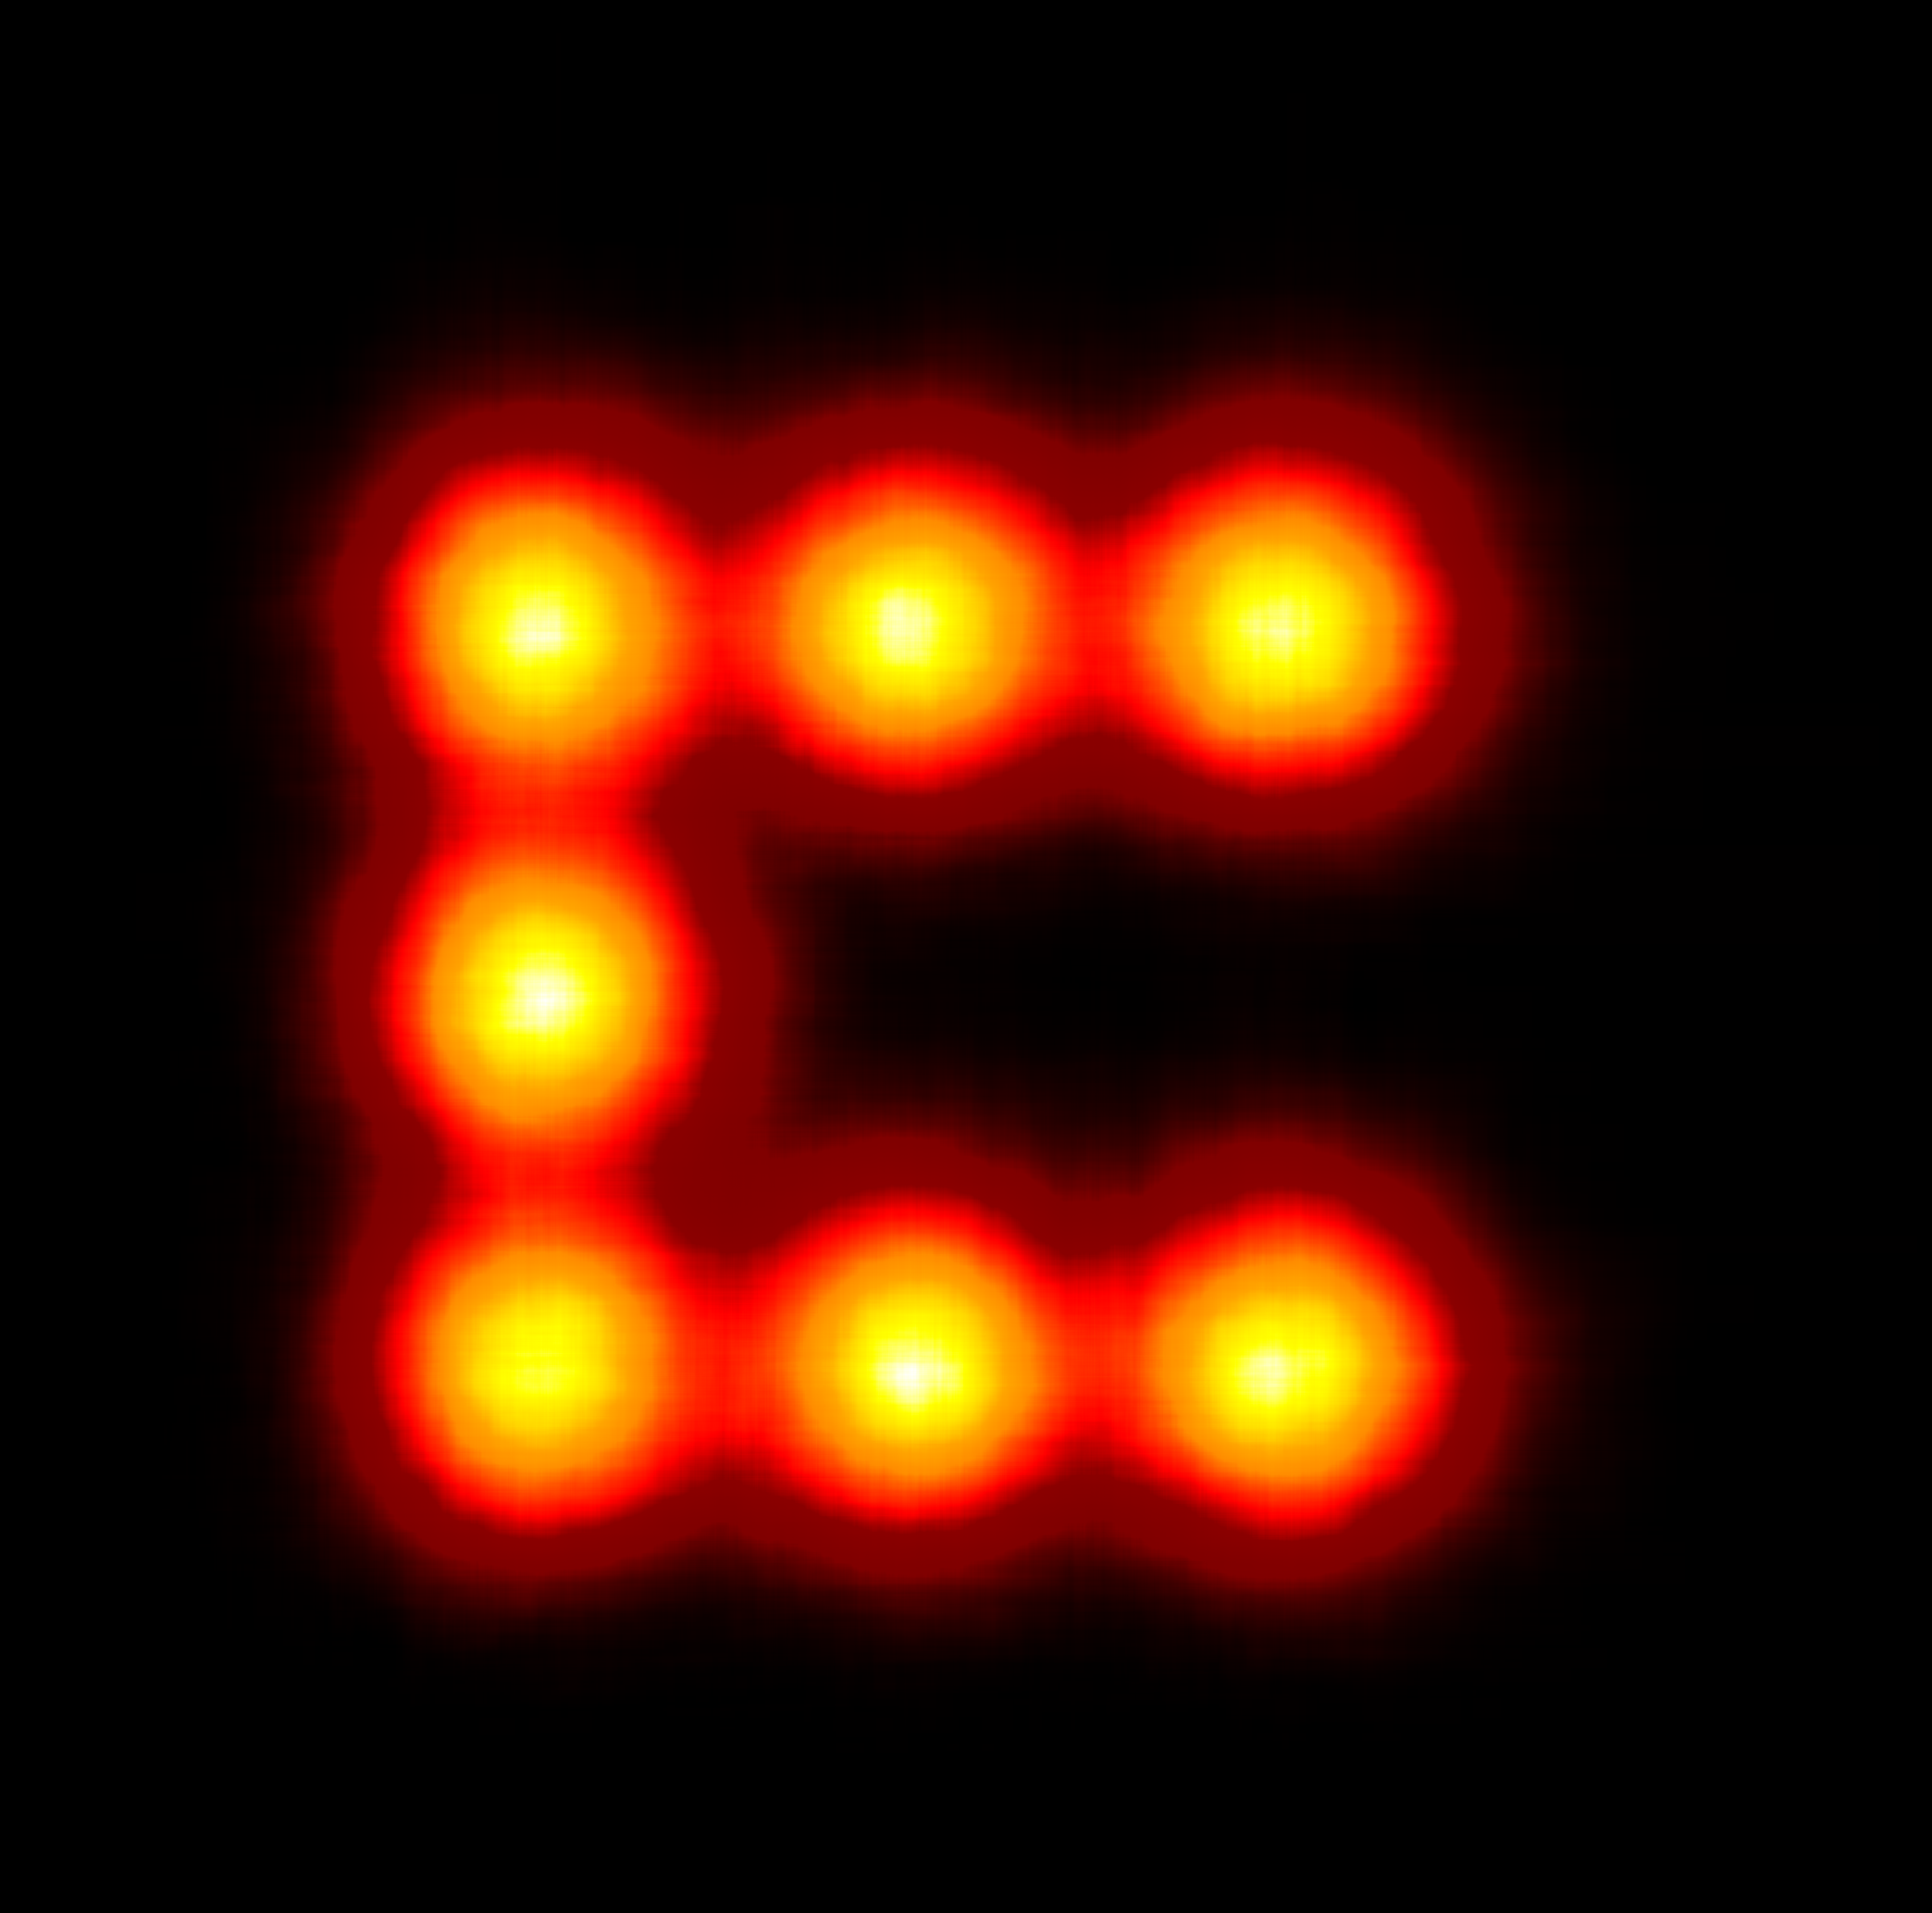

In [21]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')